# Base Transformer Pipeline

In this notebook we will explore the basic pipeline for Training Transformer models to classify future price trends on 15min interval stock data. We will be working with a portfolio of highly correlated stocks: AAPL, GOOG, QCOM, and TSLA. These stock were highly correlated around Aug - Oct 2022. The stock dataset does not contains timestamps, prices and trading volume, but does not contin any target variables.
- Timestamps &#8594; Interval
- Open/Close/High/Low Prices &#8594; Ratio
- Trading Volume &#8594; Ratio

 We will create the target variable by taking the midpoint of Open/Close prices for M future days and then averaging these values. This target variable is Oridnal and has 3 possible classes: 
- 0 - downward price movement
- 1 - no change
- 2 - upward price movement

The price movements are derived by a threshold that is defined using the IQR method to detect outliers. Currently we use a limit of 1, and every Q1 outlier is classified as "0 - downward price movement", every Q3 outlier is classified as "2 - upward price movement", and all inliers are classified as: "1 - no change".

For this problem we will only perform predictions on the next portion of the sequence

## Models

The main model we will be testing in this notebook is a Transformer Encoder. Typically a Transformer has an Encoder and Decoder portion, where the Encoder learns information about which parts of the input sequence are relevant to eachother. The Decoder does the opposite, it takes the continuouss representation learned by the Encoder and learns to generate an ordered output sequence. For the Time Series Classifiecation problem it is unecessary to include the Decoder, we can simply use the Encoder to learn relative correlations of the inputs and add a Vanilla Feed Forward Neural Network to the end of the Encoder Blocks to obtain the desired classification. [Source](https://userweb.cs.txstate.edu/~amk181/AIME_LSTM_Attention_vs_Transformer.pdf).

The Transformer Encoder also relies on positional encoding in order to implement this, we will first project the input vectors into high dimensional space as done [here](https://arxiv.org/pdf/2010.02803.pdf), and then add the positional Encoding as done in the [original paper](https://arxiv.org/pdf/1706.03762.pdf).


In order to compare how effective the Transformer is in modeling seuqential data, we will compare its results to:
- Baseline Model (uses previous predictions)
- Linear Model
- Neural Network
- LSTM

### Library Import

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

### Local Imports

Get base dir for imports, this allows us to look in the main algotrading folder to import local modules

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.path.abspath('..'), '..'))
sys.path.append(BASE_DIR)

In [3]:
from data_utils import *
from window_generator import WindowGenerator
from models.basic_transformer import TransformerModel

### Ensure that GPU is available

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Get the Data
Place all stocks in a Dictionary of DataFrames

In [5]:
def get_trading_times(df):
    ''' Obtains a cleaned stock price DataFrame, with trading times ranging
        from 9:30 - 4:00
       '''
    
    # ensure that all trading times are sequential, pad missing data with NaNs
    df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='15min'))
       
    # get regular trading times
    dayofweek = df.index.dayofweek
    hour = df.index.hour
    minute = df.index.minute
    
    df = df.iloc[(dayofweek <= 4)                  # only get M-F
                 & ~((hour == 9) & (minute < 30))  # remove less than 9:30
                 & ((hour >= 9) & (hour <= 16))    # hours 9-16
                 & ~((hour == 16) & (minute > 0))] # remove greater than 16:00
    
    # remove NaNs
    df = df[~df.isna().all(axis=1)]
    
    return df

In [6]:
from glob import glob
import re

get_name = lambda x : re.search('\w+(?=_15min)', x).group()

# get all data .csvs
data_paths = glob(os.path.join(BASE_DIR, r'data\raw\*.csv'))

stock_dfs = {}
for _path in data_paths:
    _df = pd.read_csv(_path, index_col=0, parse_dates=True, infer_datetime_format=True).dropna()

    # filter for regular trading times
    _df = get_trading_times(_df)

    # add price_trend to each stock DataFrame
    _df = get_numeric_price_trend(_df, n=4)

    stock_dfs.update({get_name(_path) : _df})

### Determine Target Variable Thresholds

In [7]:
def get_iqr(ser):
    q1 = ser.quantile(0.25)
    q3 = ser.quantile(0.75)
    iqr = q3 - q1

    return q1, q3, iqr

def get_iqr_thresholds(x, lim=1.):
    q1, q3, iqr = get_iqr(x)

    lower = q1 - lim*iqr
    upper = q3 + lim*iqr

    return lower, upper


For each stock get upper/lower IQR thresholds to dermine price movement class

In [8]:
iqr_lim = 0.25 
thresholds = {}

for name in stock_dfs.keys():
    lower, upper = get_iqr_thresholds(stock_dfs[name]['price_trend'], iqr_lim)
    thresholds.update({name : (lower, upper)})


Plot Price Movements with lower/upper thresholds

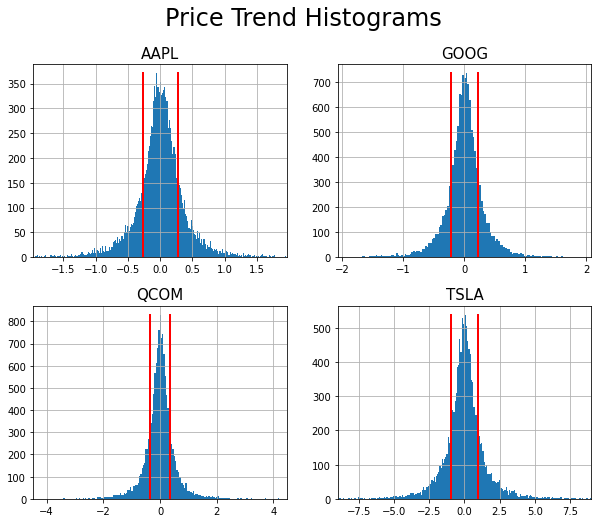

In [9]:
fig = plt.figure(figsize=(10, 8))

for i, name in enumerate(stock_dfs.keys()):
    ax = plt.subplot(2, 2, i + 1)

    # plot Numer Price Trend Histogram
    ax_obj = stock_dfs[name]['price_trend'].hist(ax=ax, bins=500)

    # get adjust x and y limits for display purposes
    ylim = [val - val//20 for val in list(ax_obj.get_ylim())]
    xlim = [val - val//2 for val in list(ax_obj.get_xlim())]

    # plot IQR lines
    lower, upper = thresholds[name]
    ax.plot([lower, lower], ylim, color='r', linewidth=2)
    ax.plot([upper, upper], ylim, color='r', linewidth=2)

    # set xlim for nice display
    ax.set_xlim(min(xlim), -1*min(xlim))
    
    # set titles and axis labels
    ax.set_title(f'{name}', size=15)


# set main title
fig.suptitle('Price Trend Histograms', size=24)

# add a bit of space
fig.subplots_adjust(hspace=0.25);
    


### Add Target Variable (Price Change) to stock DataFrames

In [10]:
# supress setting with copy warning
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None

for name in stock_dfs.keys():

    # get stock DataFrame
    df = stock_dfs[name]

    # get threshold bounds
    lower, upper = thresholds[name]

    # place target variable in DataFrame
    # obtain target variable
    df['price_change'] = 1 # price stays the same
    df['price_change'][df['price_trend'] < lower] = 0 # downward price movement
    df['price_change'][df['price_trend'] > upper] = 2 # upward prive movement

# return setting with copy warning to default 
pd.options.mode.chained_assignment = 'warn'

### Place plots of number of each class for each stock

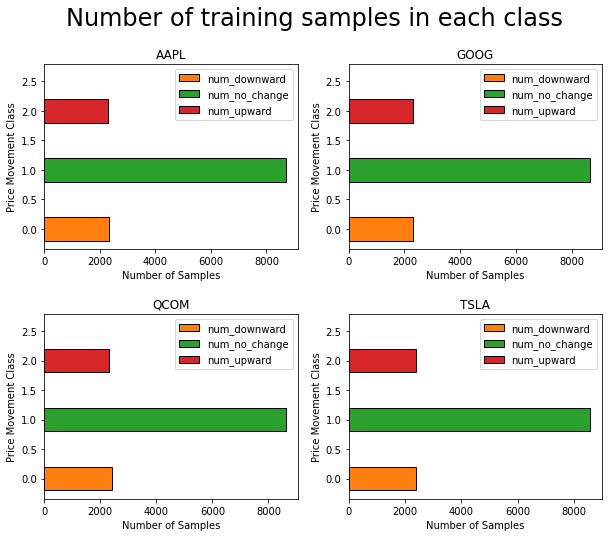

In [11]:
fig = plt.figure(figsize=(10, 8))

for i, name in enumerate(stock_dfs.keys()):
    # get plotting axes
    ax = plt.subplot(2, 2, i + 1)

    # get stock DataFrame
    df = stock_dfs[name]

    # compute class counts
    down = np.sum(df.price_change == 0)
    none = np.sum(df.price_change == 1)
    up = np.sum(df.price_change == 2)

    ax.barh([2.25], [0]) # expand to fit the legend
    ax.barh([0], [down], height=0.4, edgecolor='k', label='num_downward')
    ax.barh([1], [none], height=0.4, edgecolor='k', label='num_no_change')
    ax.barh([2], [up], height=0.4, edgecolor='k', label='num_upward')
    ax.set_title(name)
    ax.set_xlabel('Number of Samples')
    ax.set_ylabel('Price Movement Class')
    ax.legend();

# set main title
fig.suptitle('Number of training samples in each class', size=24)

# add a bit of space
fig.subplots_adjust(hspace=0.35);


### FUTURE -- Add more features
- Price/Volume Differences
- Time Encoding
- Technical Indicators

### Get train, valid, test splits for each stock

In [12]:
train_dfs = {}
valid_dfs = {}
test_dfs = {}

split_dfs = {}

for name in stock_dfs.keys():

    # get stock DataFrame
    df = stock_dfs[name]

    train = df.loc[:'2022-02-01']
    valid = df.loc['2022-02-02':'2022-07-01']
    test = df.loc['2022-07-01':]

    train_dfs.update({name : train})
    valid_dfs.update({name : valid})
    test_dfs.update({name : test})
    
    split_dfs.update({name : [train, valid, test]})

### Test Window Generator

In [48]:
# use shift=0 since the targets are aligned with each feature row
aapl_gen = WindowGenerator(
                input_width=32, label_width=1, shift=0, 
                dfs=split_dfs['AAPL'],
                remove_cols=['price_change', 'price_trend'],
                batch_size=32, 
                label_columns=['price_change'])

In [49]:
for inputs, labels, sample_weights in aapl_gen.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (32, 32, 5)
Labels shape (batch, time, features): (32, 1, 1)


Check that each window is standardized

In [ ]:
tf.math.reduce_std(inputs, axis=1)

### Start Training Models

In [16]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [51]:
single_step_gens = []
norm_single_gens = []
window_generators = []

for name in split_dfs.keys():
    single_gen = WindowGenerator(
        input_width=1, label_width=1, shift=0,
        dfs=split_dfs[name],
        batch_size=32, 
        label_columns=['price_change'])

    norm_single_gen = WindowGenerator(
                input_width=32, label_width=1, shift=0, 
                dfs=split_dfs[name],
                remove_cols=['price_change', 'price_trend'], batch_size=32, 
                label_columns=['price_change'], no_sequence=True)

    data_gen = WindowGenerator(
                input_width=32, label_width=1, shift=0, 
                dfs=split_dfs[name],
                remove_cols=['price_change', 'price_trend'], batch_size=32, 
                label_columns=['price_change'])
    
    single_step_gens.append(single_gen)
    window_generators.append(data_gen)
    norm_single_gens.append(norm_single_gen)
        

In [52]:
train_performance = {}
val_performance = {}

In [53]:
train_metrics = []
val_metrics = []
for data_gen in single_step_gens:
    baseline = Baseline(label_index=data_gen.column_indices['price_change'])

    baseline.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'],
                     weighted_metrics=['accuracy'])

    train_metrics.append(baseline.evaluate(data_gen.train))
    val_metrics.append(baseline.evaluate(data_gen.valid))

88/88 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.2600 - weighted_accuracy: 0.4405


In [54]:
train_performance['Baseline'] = train_metrics
val_performance['Baseline'] = val_metrics

Stream line the process with a conveincence function

In [55]:
def compile_and_fit(model, window, lr=1e-4, max_epochs=100, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
                  weighted_metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.valid,
                        callbacks=[early_stopping])
    return history

### Train a Linear Model

In [59]:
linear = tf.keras.Sequential([
    layers.Dense(units=3, activation='softmax')
])

linear.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    weighted_metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [60]:
train_metrics = []
val_metrics = []

EPOCHS = 2
for e in range(1, EPOCHS+1):
    print(f'\nMAIN EPOCH: {e}')
    for data_gen in norm_single_gens:
        print()
        
        history = linear.fit(
                            data_gen.train, epochs=1,
                            validation_data=data_gen.valid)

        train_metrics.append(linear.evaluate(data_gen.train))
        val_metrics.append(linear.evaluate(data_gen.valid))


MAIN EPOCH: 1

87/87 [==============================] - 0s 3ms/step - loss: 1.5676 - sparse_categorical_accuracy: 0.2964 - weighted_sparse_categorical_accuracy: 0.4020

87/87 [==============================] - 0s 3ms/step - loss: 1.5458 - sparse_categorical_accuracy: 0.2927 - weighted_sparse_categorical_accuracy: 0.4473

87/87 [==============================] - 0s 3ms/step - loss: 1.5161 - sparse_categorical_accuracy: 0.2637 - weighted_sparse_categorical_accuracy: 0.3930

87/87 [==============================] - 0s 3ms/step - loss: 1.3670 - sparse_categorical_accuracy: 0.2510 - weighted_sparse_categorical_accuracy: 0.4067

MAIN EPOCH: 2

87/87 [==============================] - 0s 3ms/step - loss: 1.5422 - sparse_categorical_accuracy: 0.2622 - weighted_sparse_categorical_accuracy: 0.4316

87/87 [==============================] - 0s 3ms/step - loss: 1.5335 - sparse_categorical_accuracy: 0.2688 - weighted_sparse_categorical_accuracy: 0.4524

87/87 [==============================] - 0s 3

In [64]:
train_performance['Linear'] = train_metrics
val_performance['Linear'] = val_metrics

### Train the Transformer Model

In [65]:
transformer_model = TransformerModel(
            n_heads=2,
            d_model=512,
            ff_dim=256,
            num_transformer_blocks=2,
            mlp_units=[256],
            n_outputs=3,
            dropout=0.1,
            mlp_dropout=0.1)

Train model on each dataset once per epoch

TODO - add new functions to make this easier

In [66]:
LEARN_RATE = 1e-4

In [67]:
transformer_model.compile(
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARN_RATE),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
                  weighted_metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [73]:
train_metrics = []
val_metrics = []

EPOCHS = 2
for e in range(1, EPOCHS+1):
    print(f'\nMAIN EPOCH: {e}')
    for window in window_generators:
        print()
        
        history = transformer_model.fit(
                            window.train, epochs=1,
                            validation_data=window.valid)

        train_metrics.append(transformer_model.evaluate(window.train))
        val_metrics.append(transformer_model.evaluate(window.valid))


MAIN EPOCH: 1

87/87 [==============================] - 1s 9ms/step - loss: 1.5284 - sparse_categorical_accuracy: 0.4897 - weighted_sparse_categorical_accuracy: 0.1589

87/87 [==============================] - 1s 9ms/step - loss: 1.5432 - sparse_categorical_accuracy: 0.4922 - weighted_sparse_categorical_accuracy: 0.1577

87/87 [==============================] - 1s 9ms/step - loss: 1.5070 - sparse_categorical_accuracy: 0.4755 - weighted_sparse_categorical_accuracy: 0.1571

87/87 [==============================] - 1s 9ms/step - loss: 1.3140 - sparse_categorical_accuracy: 0.5124 - weighted_sparse_categorical_accuracy: 0.2328

MAIN EPOCH: 2

87/87 [==============================] - 1s 9ms/step - loss: 1.5109 - sparse_categorical_accuracy: 0.4912 - weighted_sparse_categorical_accuracy: 0.1672

87/87 [==============================] - 1s 9ms/step - loss: 1.5297 - sparse_categorical_accuracy: 0.4973 - weighted_sparse_categorical_accuracy: 0.1727

87/87 [==============================] - 1s 9

In [74]:
train_metrics

[[0.9061693549156189, 0.7164942622184753, 0.33285611867904663],
 [0.8876495361328125, 0.719203770160675, 0.33286476135253906],
 [0.9235844612121582, 0.7082219123840332, 0.33282914757728577],
 [0.9556822180747986, 0.6702313423156738, 0.36543354392051697],
 [0.8584238290786743, 0.7150993943214417, 0.3462086319923401],
 [0.8472573757171631, 0.7163934707641602, 0.35327017307281494],
 [0.8722885847091675, 0.7004302740097046, 0.3995167315006256],
 [0.9225524663925171, 0.6606997847557068, 0.40595096349716187]]

In [75]:
val_metrics

[[1.5284138917922974, 0.4897371232509613, 0.1589130461215973],
 [1.5431854724884033, 0.49220165610313416, 0.15770798921585083],
 [1.5070111751556396, 0.4755043089389801, 0.15706345438957214],
 [1.3139506578445435, 0.5124234557151794, 0.232777401804924],
 [1.5109220743179321, 0.4911775290966034, 0.1671837866306305],
 [1.529694676399231, 0.49727964401245117, 0.17274165153503418],
 [1.5008020401000977, 0.4920749366283417, 0.21911107003688812],
 [1.2943109273910522, 0.5286279916763306, 0.28556808829307556]]

In [76]:
train_performance['Transformer'] = train_metrics
val_performance['Transformer'] = val_metrics

In [77]:
train_performance

{'Baseline': [[nan, 0.1375955492258072, 0.33333343267440796],
  [nan, 0.13183993101119995, 0.33333346247673035],
  [nan, 0.14565469324588776, 0.3333335220813751],
  [nan, 0.15299977362155914, 0.33333370089530945]],
 'Transformer': [[0.9061693549156189, 0.7164942622184753, 0.33285611867904663],
  [0.8876495361328125, 0.719203770160675, 0.33286476135253906],
  [0.9235844612121582, 0.7082219123840332, 0.33282914757728577],
  [0.9556822180747986, 0.6702313423156738, 0.36543354392051697],
  [0.8584238290786743, 0.7150993943214417, 0.3462086319923401],
  [0.8472573757171631, 0.7163934707641602, 0.35327017307281494],
  [0.8722885847091675, 0.7004302740097046, 0.3995167315006256],
  [0.9225524663925171, 0.6606997847557068, 0.40595096349716187]],
 'Linear': [[1.1530777215957642, 0.21074043214321136, 0.3326411247253418],
  [1.1456091403961182, 0.18735362589359283, 0.33508434891700745],
  [1.1242986917495728, 0.17036864161491394, 0.3166752755641937],
  [1.1194484233856201, 0.17191676795482635, 0.

In [78]:
val_performance

{'Baseline': [[nan, 0.27243590354919434, 0.4618994891643524],
  [nan, 0.27546629309654236, 0.4803633987903595],
  [nan, 0.2850017845630646, 0.4566367566585541],
  [nan, 0.2599714994430542, 0.44045841693878174]],
 'Transformer': [[1.5284138917922974, 0.4897371232509613, 0.1589130461215973],
  [1.5431854724884033, 0.49220165610313416, 0.15770798921585083],
  [1.5070111751556396, 0.4755043089389801, 0.15706345438957214],
  [1.3139506578445435, 0.5124234557151794, 0.232777401804924],
  [1.5109220743179321, 0.4911775290966034, 0.1671837866306305],
  [1.529694676399231, 0.49727964401245117, 0.17274165153503418],
  [1.5008020401000977, 0.4920749366283417, 0.21911107003688812],
  [1.2943109273910522, 0.5286279916763306, 0.28556808829307556]],
 'Linear': [[1.5675842761993408, 0.2963629961013794, 0.40204453468322754],
  [1.545818567276001, 0.29270946979522705, 0.44725921750068665],
  [1.516089677810669, 0.2636887729167938, 0.3929670751094818],
  [1.367013931274414, 0.25099027156829834, 0.4066938

### Save model for future usage

In [18]:
transformer_model.summary()

Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding (Posit  multiple                 3584      
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder (Transf  multiple                 2362624   
 ormerEncoder)                                                   
                                                                 
 transformer_encoder_1 (Tran  multiple                 2362624   
 sformerEncoder)                                                 
                                                                 
 global_average_pooling1d (G  multiple                 0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               multiple            

In [19]:
transformer_model.save('models/basic_transformer_checkpoint', include_optimizer=True)

INFO:tensorflow:Assets written to: models/basic_transformer_checkpoint\assets


INFO:tensorflow:Assets written to: models/basic_transformer_checkpoint\assets


In [22]:
from tensorflow_addons.layers import multihead_attention

custom_objects={
    'MultiHeadAttention' : multihead_attention.MultiHeadAttention,
    'TransformerModel' : TransformerModel}

reconstructed_model = keras.models.load_model('models/basic_transformer_checkpoint',
                                              custom_objects=custom_objects)


In [24]:
train_metrics = []
val_metrics = []
for data_gen in window_generators:

    compile_and_fit(reconstructed_model, data_gen, lr=1e-4,
                    patience=2, max_epochs=2)

    train_metrics.append(transformer_model.evaluate(data_gen.train))
    val_metrics.append(transformer_model.evaluate(data_gen.valid))

Epoch 1/2
638/638 [==============================] - 40s 59ms/step - loss: 0.8315 - sparse_categorical_accuracy: 0.6993 - weighted_sparse_categorical_accuracy: 0.3950 - val_loss: 0.8886 - val_sparse_categorical_accuracy: 0.7210 - val_weighted_sparse_categorical_accuracy: 0.6870
Epoch 2/2
174/638 [=======>......................] - ETA: 25s - loss: 0.6626 - sparse_categorical_accuracy: 0.7633 - weighted_sparse_categorical_accuracy: 0.6517

KeyboardInterrupt: 